0. Подготовка данных
-----------------------------------------------------------------
*****************************************************************
Загрузите данные из *.csv файла.  Каждая строка – это событие.  
`p1_fraud`, `p2_fraud`, `p3_fraud` – априорные вероятности фрода с точки зрения различных экспертных систем.   
`CLASS` показывает, действительно ли транзакция была фродовой. (`G` – подлинная транзакция, `F` – фродовая, `U` – неизвестно)
*****************************************************************

In [1]:
import pandas as pd

df = pd.read_csv('выгрузка.csv', sep=';')
'Данных в выгрузке {}'.format(len(df))

'Данных в выгрузке 29304'

Посмотрим на вид данных

In [2]:
df.head(2).transpose()

,0,1
EVENT_TIME,2015-12-15 01:09:38,2015-12-15 01:18:24
USER_HASH,7215be4441716d2f96d932ecf20e324145933912,62f4b9133f70c5d06b8789182e7728e7aa0dd7f9
EVENT_TYPE,PAYMENT,PAYMENT
EVENT_TYPE_EX,CLOSE_ACCOUNT,RURPAYJURSB
AMOUNT,97207.1,500
X2,1940-06-02 00:00:00,1981-07-11 00:00:00
X3,bb64-:2c7eeb2a151:f01a1461-,f9b1-:2ea1a82a151:3b9c59-
X4,f7fe0766c3,790568bcfa
X5,8251ac24fc,e7d835c559
X6,a0e4def3e5,a0e4def3e5


Узнаем, сколько записей имеют класс U (Unknown)

In [3]:
df.groupby('CLASS').size().to_frame('COUNT')

,COUNT
CLASS,
F,9646
G,19124
U,534


И отбросим такие записи

In [4]:
df = df[df.CLASS != 'U']

Проверим, есть ли в необходимых полях незаполненные данные  
Будем проверять только поля, хранящие числа

In [5]:
ALL_CRITERIES = ['AMOUNT', 'X9', 'X10', 'X13', 'X14', 'X15', 'X17', 'X18', 'X22']

having_nan = [criteria for criteria in ALL_CRITERIES if df[[criteria]].isnull().values.any()]
having_nan

['AMOUNT', 'X22']

Для каждого столбца заполним недостающие места медианой для сохранения распределения

In [6]:
df = df.fillna(df.mean(numeric_only=True))

1. Построение графиков, выявление признаков
-----------------------------------------------------
*****************************************************
1. Напишите функцию, строящую на плоскости точки от двух переменных (Xi, Xj) Сами Xi и Xj подаются на вход системы.
2. Проанализируйте всевозможные комбинации признаков. (Каково их количество, кстати?)
Выберете 2-3 наиболее характерных пары признаков и сохраните их в *.jpg файлах.
*****************************************************

Подготовим параметры для дальнейшей визуализации

In [7]:
import matplotlib
% matplotlib inline

matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15, 10)

Разобъем данные на фродовые и легитимные

In [8]:
df_f = df[df.CLASS == 'F']
df_g = df[df.CLASS == 'G']

Напишем функцию, строющую зависимость одной величины от другой

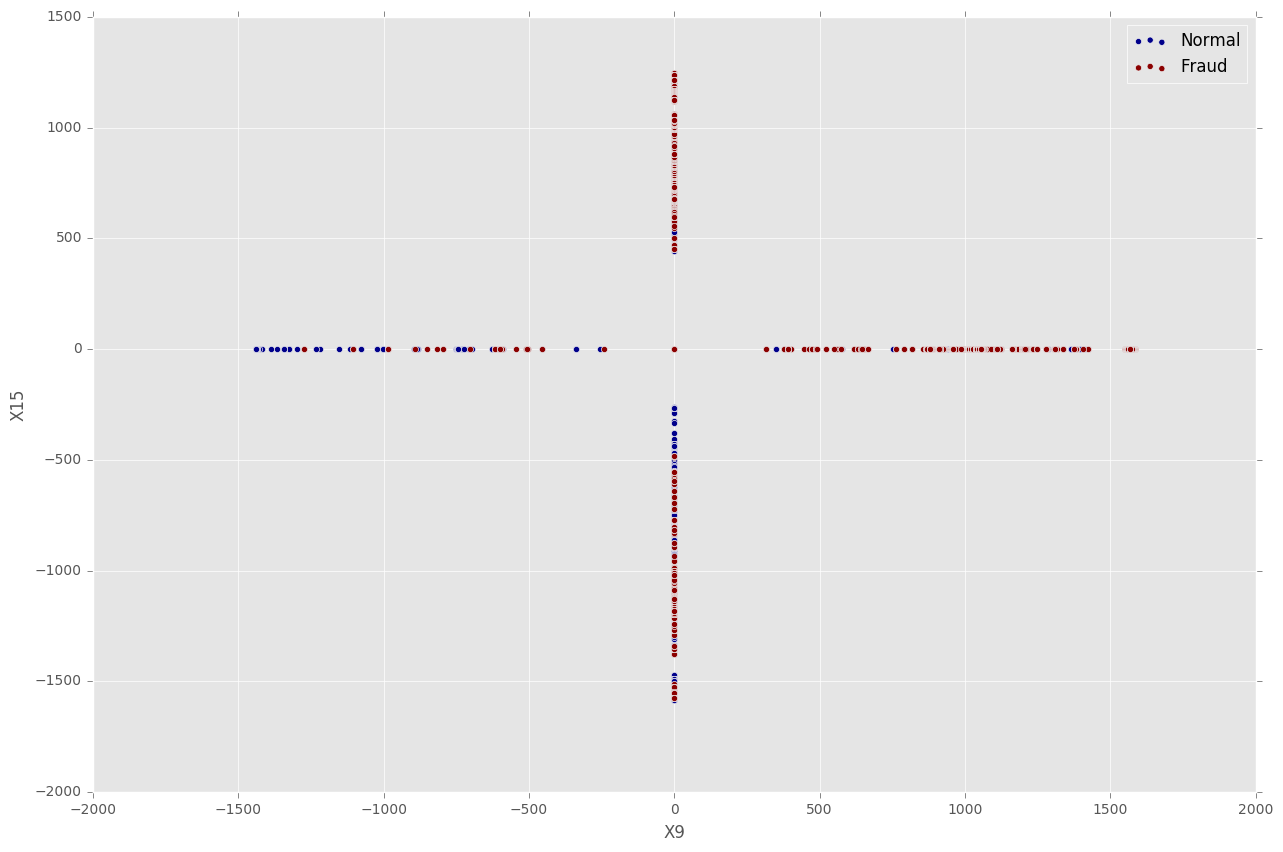

In [9]:
def plot_scatter(x, y):
    ax = df_g.plot.scatter(x, y, color='DarkBlue', label='Normal');
    df_f.plot.scatter(x, y, color='DarkRed', label='Fraud', ax=ax);

plot_scatter('X9', 'X15')

Перебирать все пары признаков долго. Для этого построим следующий график:

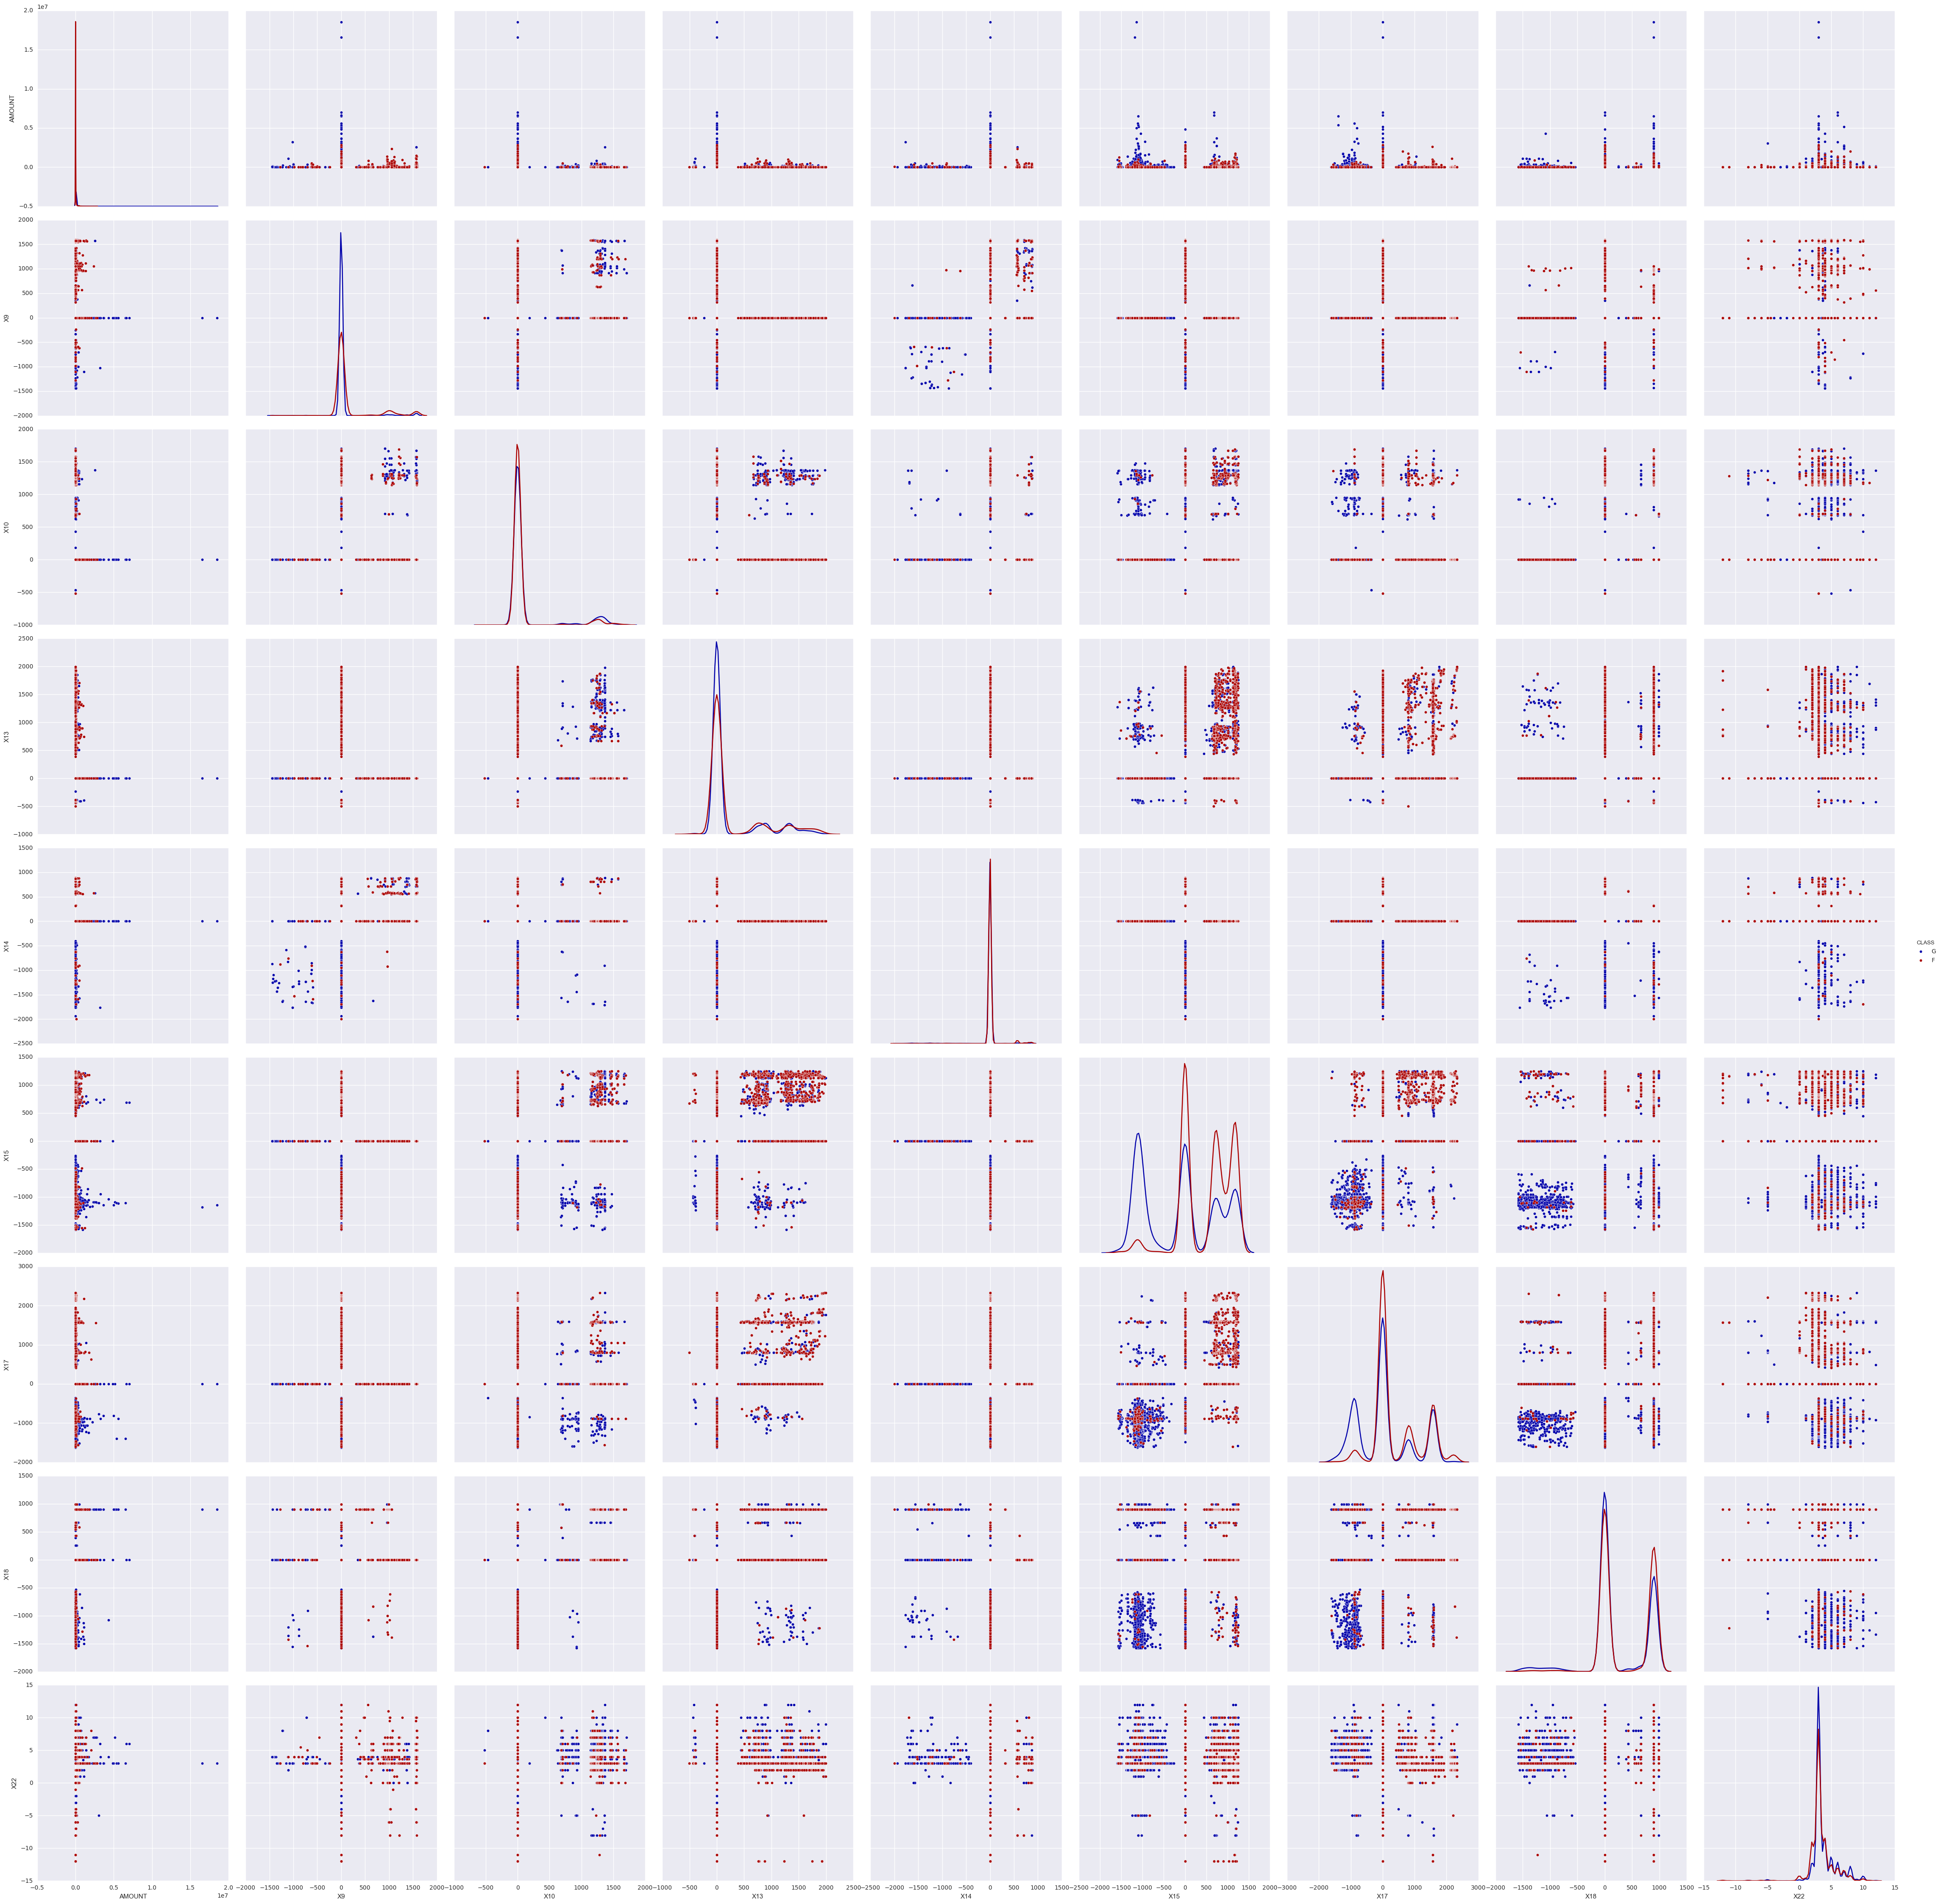

In [10]:
import seaborn as sns

df_for_matrix = df[ALL_CRITERIES + ['CLASS']]
sns.pairplot(df_for_matrix, hue='CLASS', palette={'G': '#0000AA', 'F': '#AA0000'}, diag_kind='kde', size=5)

По диагонали была выставлена плотность распределения данных признаков - глядя на ее вид, можно оценить информативность признака и решить, насколько целесообразно его использование.

2. Расчет TP, FP, TN, FN
-------------------------------------------------------

*******************************************************

1. Предположим, что решающее правило >=0.5 – фрод, в остальных случаях – не фрод. По указанной выборки рассчитать: true positive, false positive, true negative, false negative для всех правил
2. Для каждой ЭС найдите порог решающего правила, для которого false positive не более 0.2

[Статья об основных параметрах на вики](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)

*******************************************************

<img src="./img.png" width="200" height="200" />

$$ TPR = \frac{TP}{TP + FN}$$

$$ FPR = \frac{FP}{FP + TN}$$

$$ FNR = \frac{FN}{TP + FN} = 1 - TRP$$

$$ TNR = \frac{TN}{TN + FP} = 1 - FPR$$

*******************************************************

In [11]:
systems = ['p{}_Fraud'.format(i + 1) for i in range(3)]

def get_params(df, system, rule, rate=True):
    
    
    FP = len(df.query('{} >= {} & CLASS == "G"'.format(system, rule)))
    TP = len(df.query('{} >= {} & CLASS == "F"'.format(system, rule)))
    
    FN = len(df.query('{} < {} & CLASS == "F"'.format(system, rule)))
    TN = len(df.query('{} < {} & CLASS == "G"'.format(system, rule)))
    
    if rate:
        return {
            'FPR': FP/(FP + TN),
            'TPR': TP/(TP + FN),
            'FNR': FN/(TP + FN),
            'TNR': TN/(TN + FP),        
        }
    else:
        return {
            'FP': FP,
            'TP': TP,
            'FN': FN,
            'TN': TN,  
            
        }
    
pd.DataFrame({system: get_params(df, system, 0.5, False) for system in systems}).transpose()

,FN,FP,TN,TP
p1_Fraud,7005,7503,11621,2641
p2_Fraud,2681,8195,10929,6965
p3_Fraud,1504,6029,13095,8142


Вычислим порог решающего правила, для которого false positive не более заданного числа

In [12]:
import numpy as np


for system in systems:
    for i in np.arange(0, 1.0, 0.01):
        result = get_params(df, system, i)
        if result['FPR'] <= 0.2:
            print('{}: {:.2f}'.format(system, i))
            break

p1_Fraud: 0.69
p2_Fraud: 0.79
p3_Fraud: 0.54


3. Построение ROC кривой. Вычисление коэффициента Джини.
-------------------------------------------------------

***************************************************************

1. Постройте ROC кривую для каждого правила.
2. Найдите коэффициент Джини для каждого правила.

[Статья о ROC-кривой на вики](https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F)  
[Ман по функции roc_curve на scikit-learn.org](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

***************************************************************

Gini coef for p1_Fraud 0.22
Gini coef for p2_Fraud 0.30
Gini coef for p3_Fraud 0.81


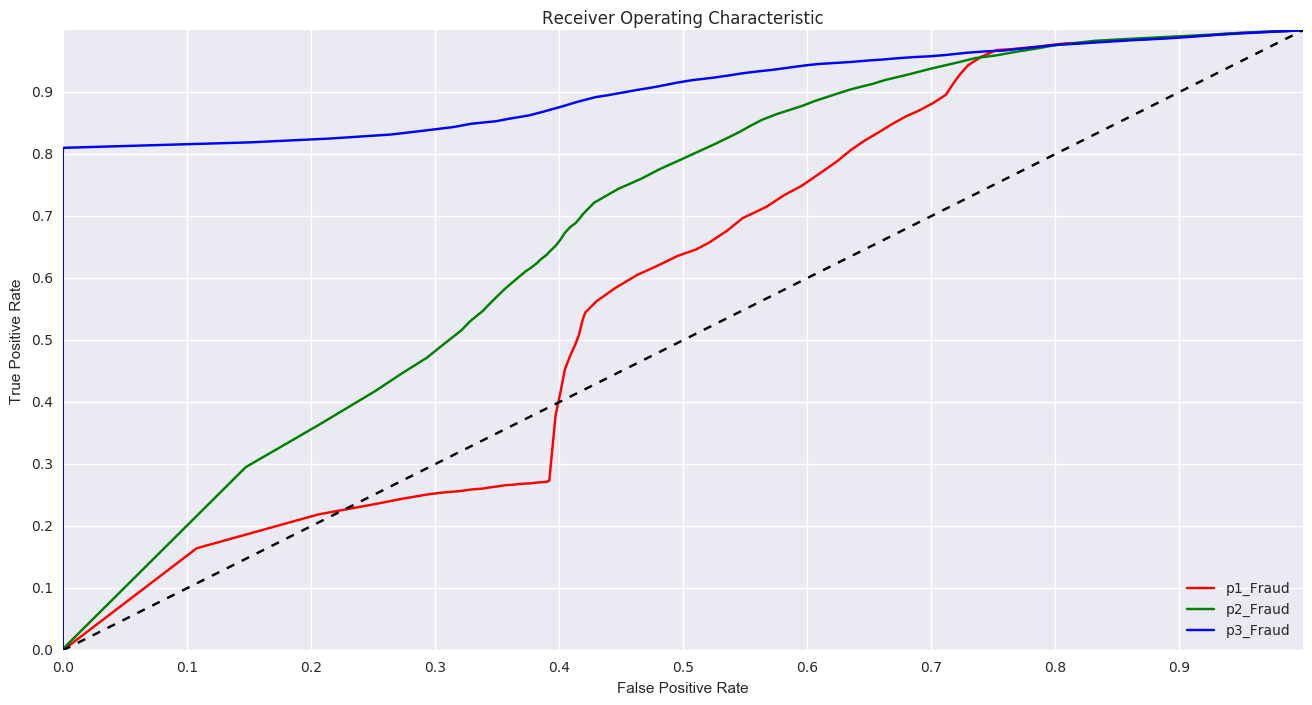

In [13]:
import matplotlib.pyplot as plt

colors = ['r', 'g', 'b', 'r--', 'b--']
matplotlib.style.use('seaborn-notebook')
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

plt.title('Receiver Operating Characteristic')
for system, color in zip(systems, colors):
    result = {i: get_params(df, system, i) for i in np.arange(0, 1.0, 0.01)}
    max_point = max(result.items(), key=lambda k_v: k_v[1]['TPR'] -  k_v[1]['FPR'])
    print('Gini coef for {} {:.2f}'.format(system, max_point[1]['TPR'] - max_point[1]['FPR']))
    df_result = pd.DataFrame(result).transpose()
    plt.plot(df_result[['FPR']], df_result[['TPR']], color, label=system)
    

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

Gini coef for p1_Fraud is 0.16
Gini coef for p2_Fraud is 0.37
Gini coef for p3_Fraud is 0.81


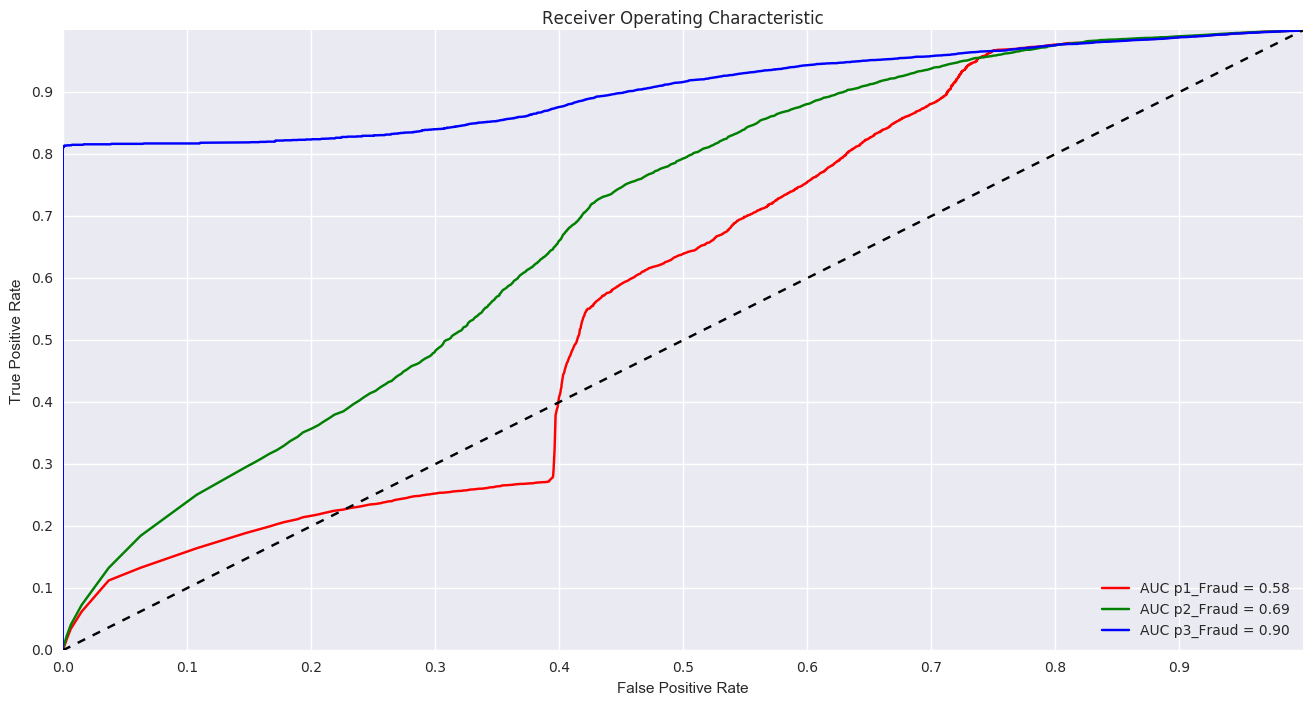

In [14]:
from sklearn.metrics import roc_curve, auc

colors = ['r', 'g', 'b', 'r--', 'b--']
matplotlib.style.use('seaborn-notebook')
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

plt.title('Receiver Operating Characteristic')
for system, color in zip(systems, colors):
    fp, tp, _ = roc_curve(df[['CLASS']], df[[system]], pos_label='F')
    roc_auc = auc(fp, tp)
    print('Gini coef for {} is {:.2f}'.format(system, 2 * roc_auc - 1))
    plt.plot(fp, tp, color, label='AUC {} = {:.2f}'.format(system, roc_auc))


plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

4. Реализация ансамблей
----------------------------------------------------
****************************************************

1. Создайте ансамбль в виде функции голосования при пороге каждого правила >=0.5, >=0.8. Найдите необходимые пороги для каждого правила ЭС, чтобы false positive
ансамбля была минимальна.
2. Создайте ансамбль в виде p = (`p1_fraud` + `p2_fraud` + `p3_fraud`)/3. Постройте ROC
кривую.
****************************************************

Создадим результат в таблице для функции голосования при отсечках 0.5 и 0.8  
А также ансамбль устредненной вероятности

In [15]:
def major_result(rule, *args):
    return True if sum(x >= rule for x in args) > len(args) / 2 else False

def get_simple_result(*args):
    return sum(args) / len(args)
    
df['p_major_05'] = df.apply(lambda row: major_result(0.5, row['p1_Fraud'], row['p2_Fraud'], row['p3_Fraud']), axis=1)
df['p_major_08'] = df.apply(lambda row: major_result(0.8, row['p1_Fraud'], row['p2_Fraud'], row['p3_Fraud']), axis=1)
df['p_simple'] = df.apply(lambda row: get_simple_result(row['p1_Fraud'], row['p2_Fraud'], row['p3_Fraud']), axis=1)

Для последнего построим ROC кривую

Gini coef for p_simple is 0.56


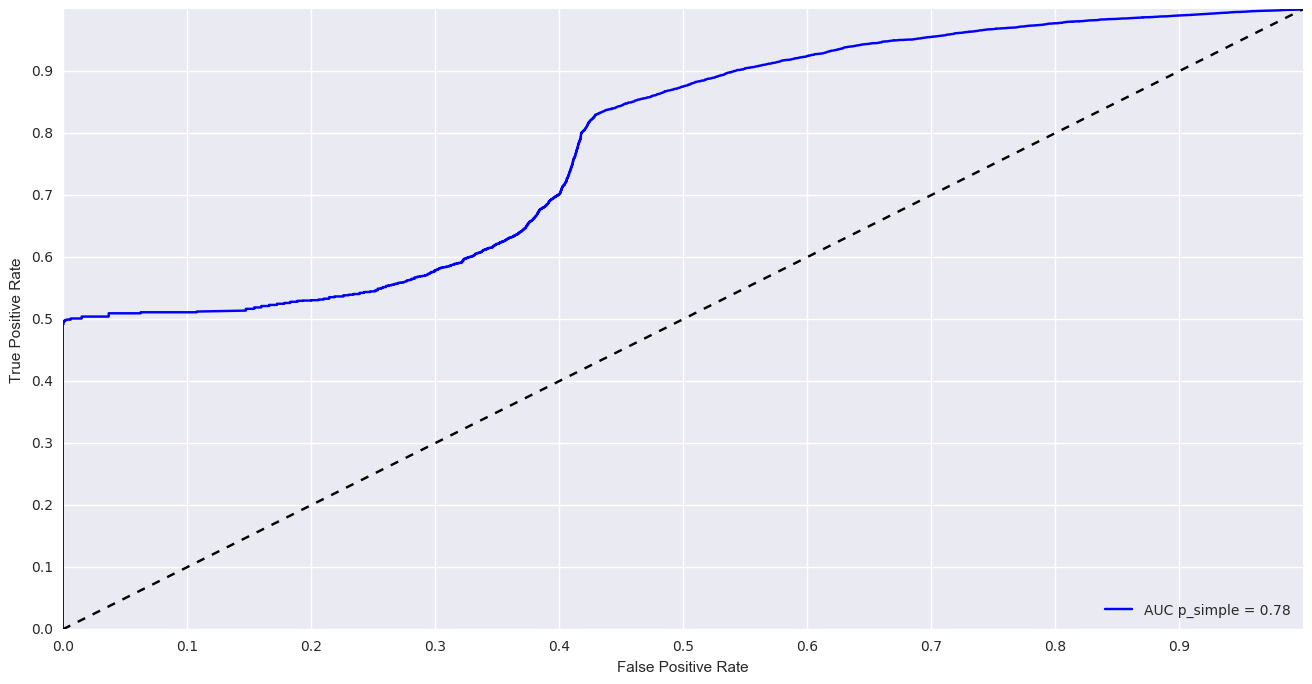

In [16]:
fp, tp, _ = roc_curve(df[['CLASS']], df[['p_simple']], pos_label='F')
roc_auc = auc(fp, tp)
print('Gini coef for {} is {:.2f}'.format('p_simple', 2 * roc_auc - 1))
plt.plot(fp, tp, 'b', label='AUC {} = {:.2f}'.format('p_simple', roc_auc))


plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

Для каждой системы вычислим порог решающего правила, для которого FPR будет минимален (ни или просто мал)

In [17]:
for system in systems:
    for i in np.arange(0, 1.0, 0.01):
        result = get_params(df, system, i)
        if result['FPR'] <= 0.01:
            print('{}: {:.2f}'.format(system, i))
            break

p1_Fraud: 0.70
p2_Fraud: 0.80
p3_Fraud: 0.55


Создадим ансамбль с наименьшим FPR - для этого в качестве отсечек возьмем значения, вычисленные ранее

In [18]:
def min_fp_result(rules, *args):
    return True if sum(prob >= rule for prob, rule in zip(args, rules)) > len(args) / 2 else False

df['p_test_min_fp'] = df.apply(lambda row: min_fp_result([0.7, 0.8, 0.55], row['p1_Fraud'], row['p2_Fraud'], row['p3_Fraud']), axis=1)

Выведем его параметры

In [19]:
TP = len(df.query('{} & CLASS == "F"'.format('p_test_min_fp')))
FP = len(df.query('{} & CLASS == "G"'.format('p_test_min_fp')))
TN = len(df.query('not {} & CLASS == "G"'.format('p_test_min_fp')))
FN = len(df.query('not {} & CLASS == "F"'.format('p_test_min_fp')))

print('TP: {}\nFP: {}\nTN: {}\nFN: {}'.format(TP, FP, TN, FN))

TP: 25
FP: 5
TN: 19119
FN: 9621


5. Создание параметризированного ансамбля
--------------------------------------------------------------
**************************************************************
1. Зададим ансамбль через параметры A, B, C:  
`p = (A*p1_fraud+B*p2_fraud+C*p3_fraud)/(A+B+C).`  
Найдите A, B, C, чтобы индекс Джини ансамбля был бы максимальным.
При каких A, B, C индекс Джини минимален?  
Найдите A, B, C для максимального true positive при условии, что false positive должен быть равен 0.1. Каков порог решающего правила?
**************************************************************

In [20]:
def get_params_for_ABC(a, b, c):
    return ((a * df['p1_Fraud'] + b * df['p2_Fraud'] + c * df['p3_Fraud']) / (a + b + c))

fp, tp, _ = roc_curve(df[['CLASS']], get_params_for_ABC(1, 1, 1), pos_label='F')
roc_auc = auc(fp, tp)

In [21]:
from itertools import product

x = range(11)
def get_result(a, b, c):
    if (a, b, c) == (0, 0, 0):
        return None
    fp, tp, _ = roc_curve(df[['CLASS']], get_params_for_ABC(a, b, c), pos_label='F')
    roc_auc = auc(fp, tp)
    return [a, b, c, 2 * roc_auc - 1]


res = map(lambda x: get_result(*x), product(x, x, x))

In [22]:
import operator


res = list(filter(None, res))

print(max(res, key=operator.itemgetter(3)))
print(min(res, key=operator.itemgetter(3)))

[0, 0, 1, 0.80954831575310404]
[1, 0, 0, 0.16466599921253366]


Произведем линейную интерполяцию для определения отсечки и TPR

In [23]:
from scipy.interpolate import interp1d


def get_TP(a, b, c):
    if (a, b, c) == (0, 0, 0):
        return None
    fp, tp, thresholds = roc_curve(df[['CLASS']], get_params_for_ABC(a, b, c), pos_label='F')
    f = interp1d(fp, thresholds)
    g = interp1d(fp, tp)
    return [a, b, c, float(g(0.1)), float(f(0.1))]

res = filter(None, map(lambda x: get_TP(*x), product(x, x, x)))

Вычислим максимальный TPR при FPR = 0.1, а также отсечку и параметры, при которых это произойдет

In [24]:
print(max(res, key=operator.itemgetter(3)))

[0, 0, 1, 0.8175409496164213, 0.5411836763005781]


6. Построение зависимости точности и полноты от pi_Fraud для каждого дня
------------------------------------------------------------------------------------
************************************************************************************
1. Постройте зависимость точности от pi_fraud для i от 1 до 3 для каждого дня.
2. Аналогично п.1 постройте зависимость полноты от pi_fraud.
************************************************************************************

In [25]:
df['EVENT_DATE'] = df.apply(lambda x: x['EVENT_TIME'].split(' ')[0], axis=1)

In [26]:
from itertools import groupby

matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

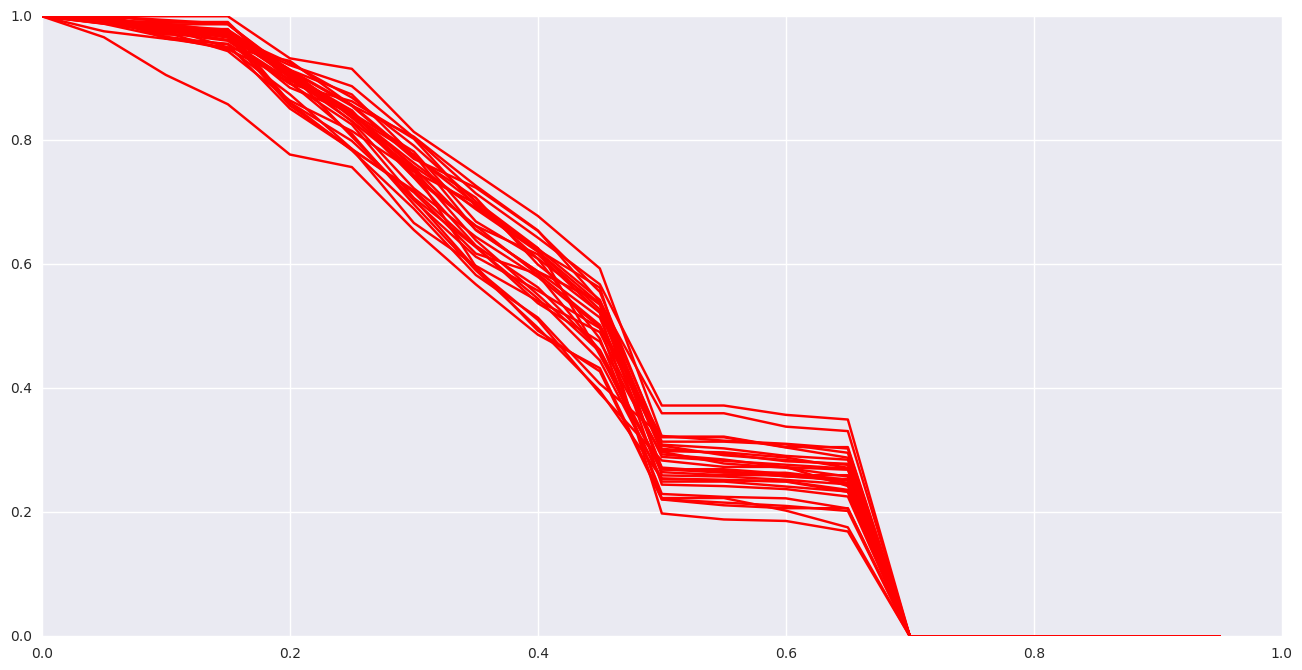

In [27]:
for date in set(df.EVENT_DATE):    
    x = []
    y_recall = []
    y_precision = []
    
    
    x = np.arange(0, 1.0, 0.05)
    y_recall = map(lambda i: get_params(df[df['EVENT_DATE'] == date], 'p1_Fraud', i)['TPR'], x)
    plt.plot(list(x), list(y_recall), 'r')
    

plt.show()

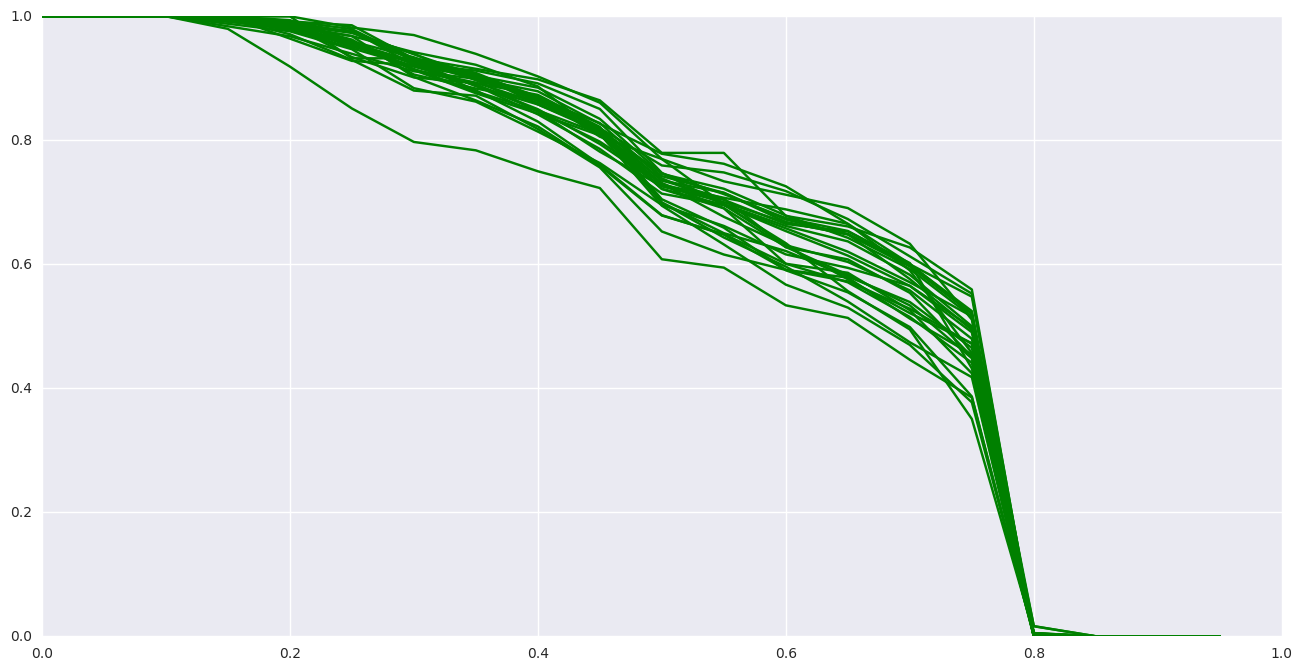

In [28]:
for date in set(df.EVENT_DATE):    
    x = []
    y_recall = []
    y_precision = []
    
    
    x = np.arange(0, 1.0, 0.05)
    y_recall = map(lambda i: get_params(df[df['EVENT_DATE'] == date], 'p2_Fraud', i)['TPR'], x)
    plt.plot(list(x), list(y_recall), 'g')
    

plt.show()

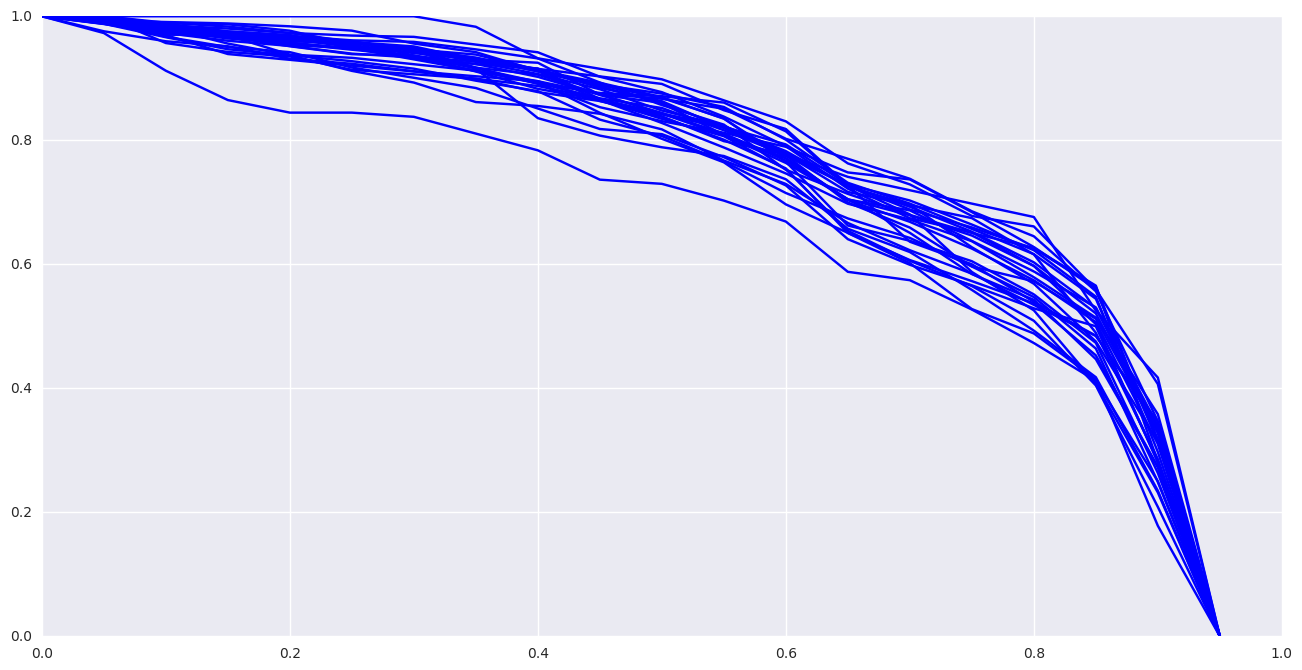

In [29]:
for date in set(df.EVENT_DATE):    
    x = []
    y_recall = []
    y_precision = []
    
    
    x = np.arange(0, 1.0, 0.05)
    y_recall = map(lambda i: get_params(df[df['EVENT_DATE'] == date], 'p3_Fraud', i)['TPR'], x)
    plt.plot(list(x), list(y_recall), 'b')
    

plt.show()

In [30]:
def get_precision(date, i, system):
    result = get_params(df[df['EVENT_DATE'] == date], system, i, False)
    try:
        return result['TP']/(result['TP'] + result['FP'])
    except ZeroDivisionError:
        return 0

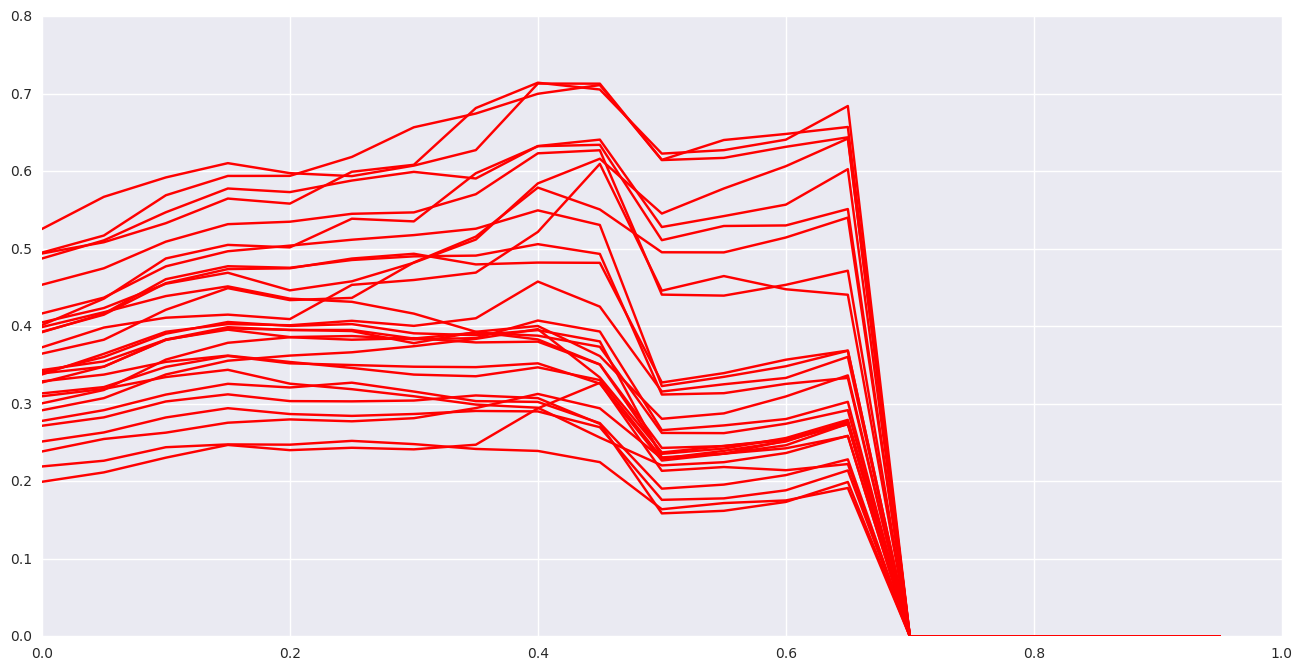

In [31]:
for date in set(df.EVENT_DATE):    
    x = []
    y_recall = []
    y_precision = []
    
    
    x = np.arange(0, 1.0, 0.05)
    y_recall = map(lambda i: get_precision(date, i, 'p1_Fraud'), x)
    plt.plot(list(x), list(y_recall), 'r')
    
plt.show()

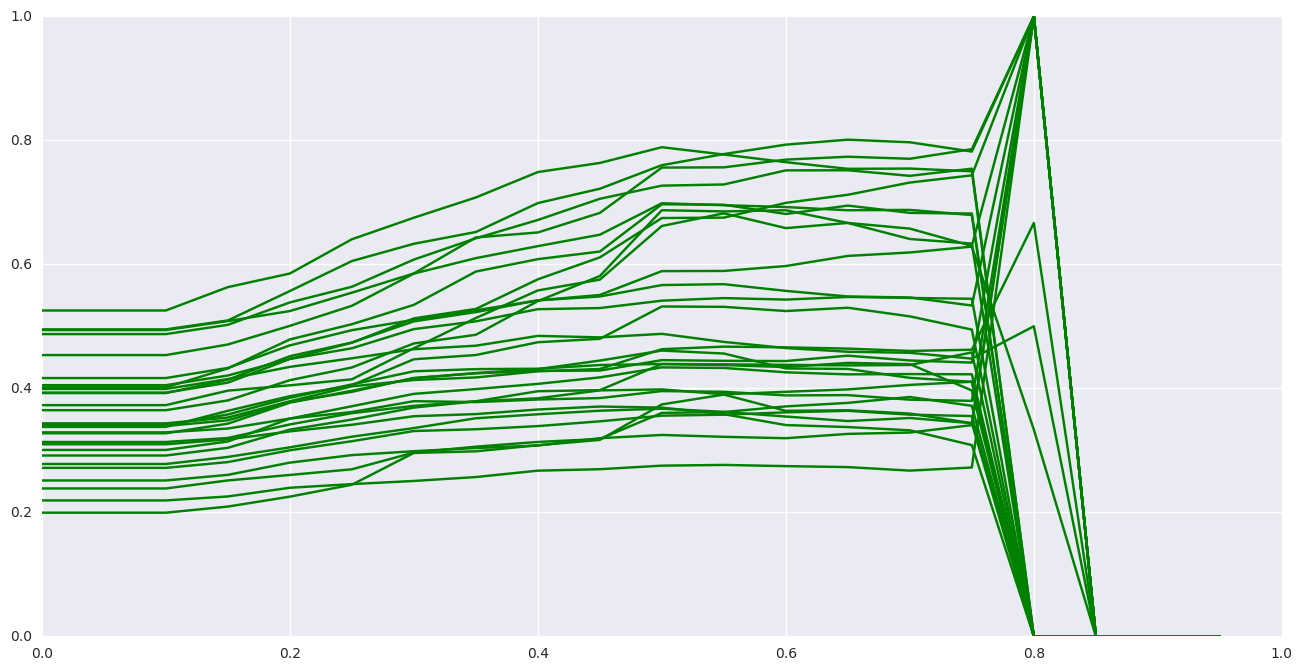

In [32]:
for date in set(df.EVENT_DATE):    
    x = []
    y_recall = []
    y_precision = []
    
    
    x = np.arange(0, 1.0, 0.05)
    y_recall = map(lambda i: get_precision(date, i, 'p2_Fraud'), x)
    plt.plot(list(x), list(y_recall), 'g')
    
plt.show()

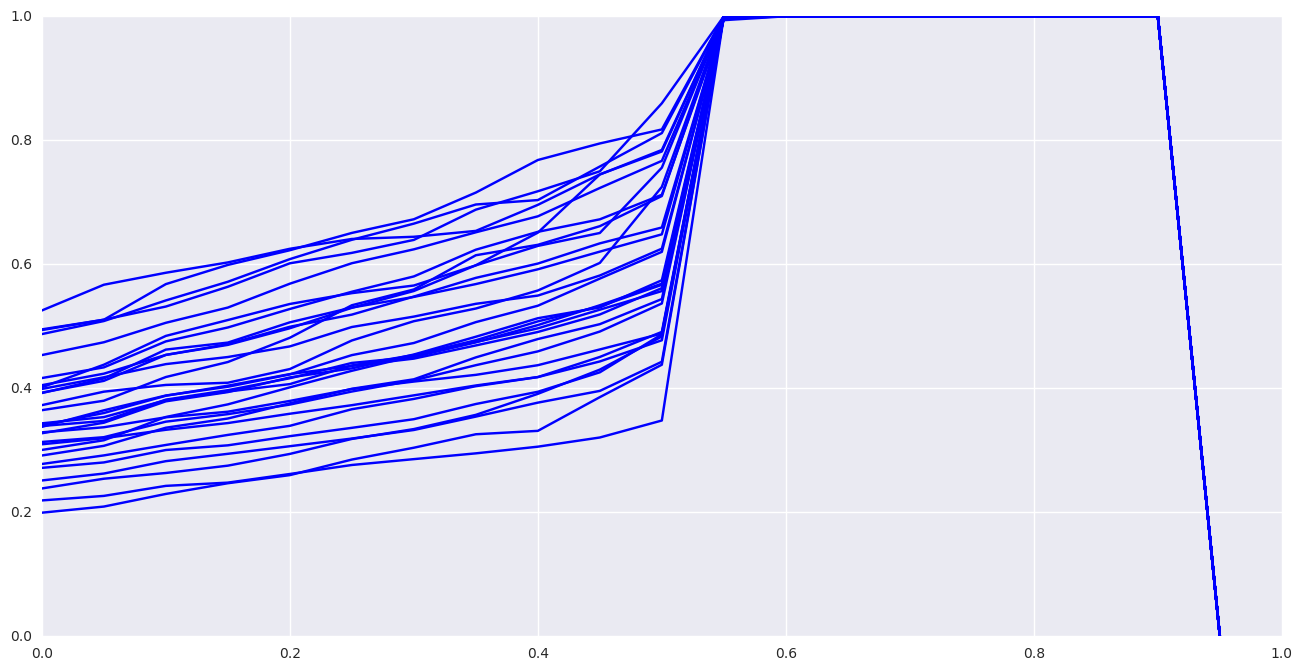

In [33]:
for date in set(df.EVENT_DATE):    
    x = []
    y_recall = []
    y_precision = []
    
    
    x = np.arange(0, 1.0, 0.05)
    y_recall = map(lambda i: get_precision(date, i, 'p3_Fraud'), x)
    plt.plot(list(x), list(y_recall), 'b')
    
plt.show()

7. Расчет CBA
---------------------------------------
***************************************
Предположим, что при верной сработки мы “спасаем” деньги клиентов, равные AMOUNT_RUB. При сработке клиента блокируют. Заблокированный клиент звонит в 90% случаев в контактный центр. Цена разговора с клиентом 40 рублей. Если клиента несправедливо заблокировали, то банк терпит репутационные издержки, оцененные в 1000 рублей. Постройте уравнение для расчета CBA. Решите это уравнение.
***************************************

In [34]:
def get_CBA(threeshold, system):
    saves = df.query('CLASS == "F" & {} > {}'.format(system, threeshold)).AMOUNT.sum()
    calls = int(len(df[df[system] > threeshold]) * 0.9) * 40
    reputations = int(len(df.query('CLASS == "G" & {} > {}'.format(system, threeshold)))) * 1000
    return saves - calls - reputations

In [40]:
import operator
x = np.arange(0, 1.0, 0.05)

new_df = pd.DataFrame(x, columns=['threeshold'])
new_df.set_index('threeshold', inplace=True)
for system in systems:
    new_df[system] = list(map(lambda i: get_CBA(i, system), x))

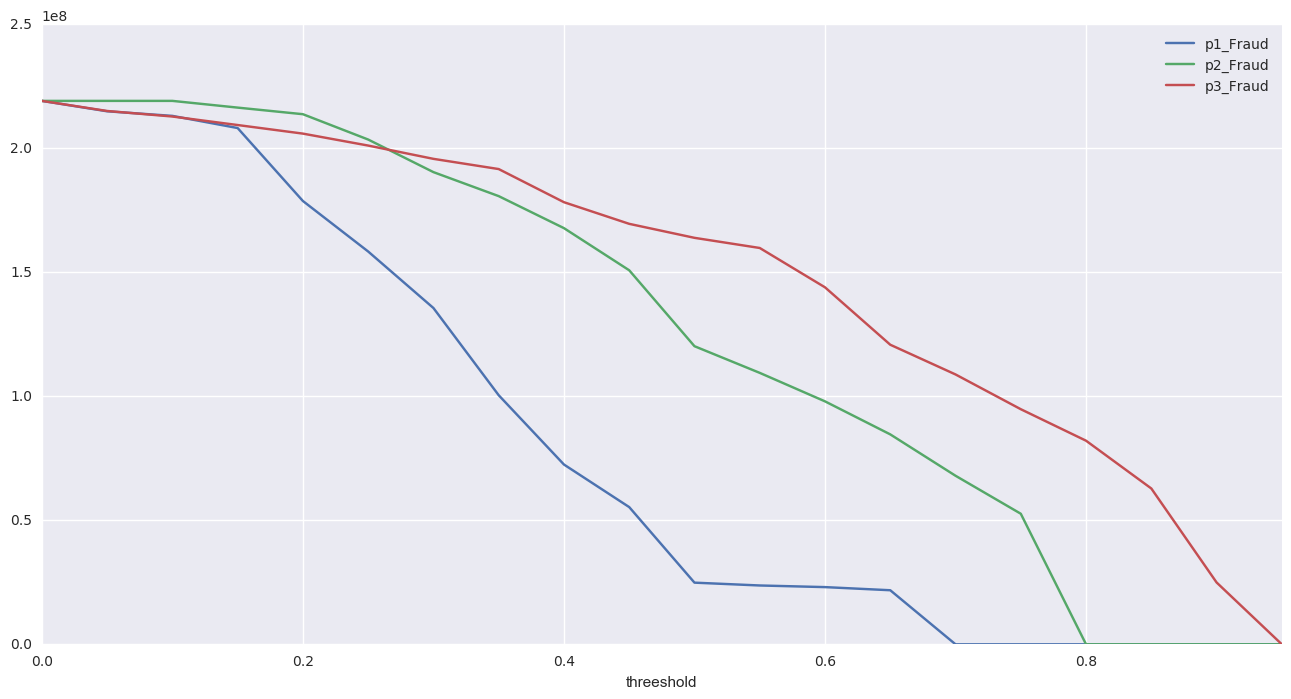

In [41]:
new_df[systems].plot(kind='line')

Как можно заметить, CBA наибольший при нулевой отсечке. Это значит, что при текущих входных данных рентабельней блокировать всех клиентов без разбора (скорее всего, из-за малых репутационных издержек и больших сумм фродовых транзакций).